# Исследование успешности игр

Основные задачи:

1. Открытие файла и изучение основной информации(первые 5 строк таблицы, info, гистограммы всего датасета) 
2. Предобработка данных: 
- Замена названий столбцов
- Преобразование типов данных 
- Обработка пропусков
- Посчитать суммарные продажи во всех регионах и запись их в отдельный столбец
3. Иследовательский анализ данных:
- сколько игр выпускалось в разные годы
- Какие платформы лидируют по продажам, растут или падают
- График «ящик с усами» по глобальным продажам игр
- Как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. 
- Выделяются ли жанры с высокими и низкими продажами?
4. Портрет пользователя каждого региона
- Самые популярные платформы (топ-5). 
- Самые популярные жанры (топ-5). Поясните разницу.
- Влияет ли рейтинг ESRB на продажи в отдельном регионе?
5. Проверка гипотез:
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action и Sports разные.

### Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

In [3]:
import seaborn as sb

In [4]:
data = pd.read_csv('/datasets/games.csv')

In [5]:
display(data.head()) # выводим первые 5 строк таблицы

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


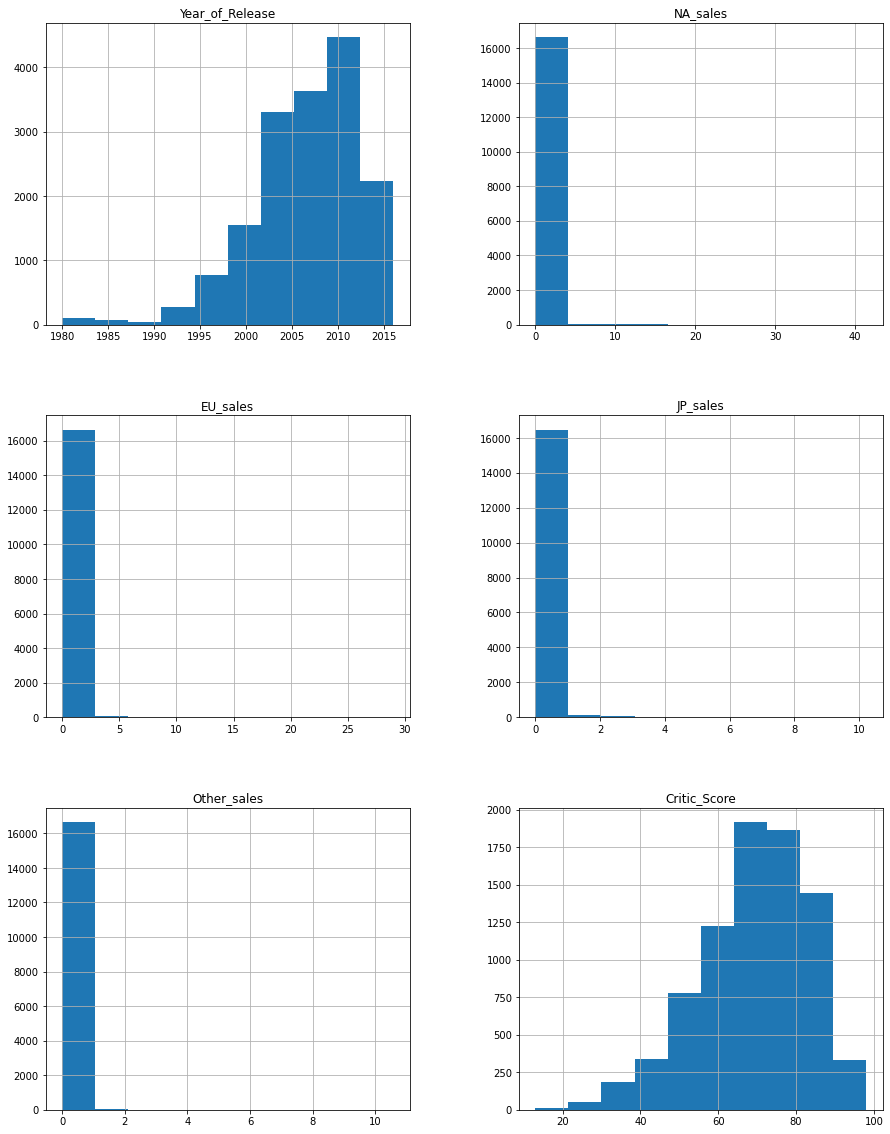

In [6]:
data.hist(figsize=(15, 20)); #изучение основной информации 

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Предобработка данных

In [8]:
data.columns = data.columns.str.lower() #приведем названия столбцов к нижнему регистру

In [9]:
data.isna().sum() #к-во пропусков в каждом столбце

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [10]:
# check
# пропущенные значения бары

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind= 'barh', figsize=(19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Количество пропусков' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) ')

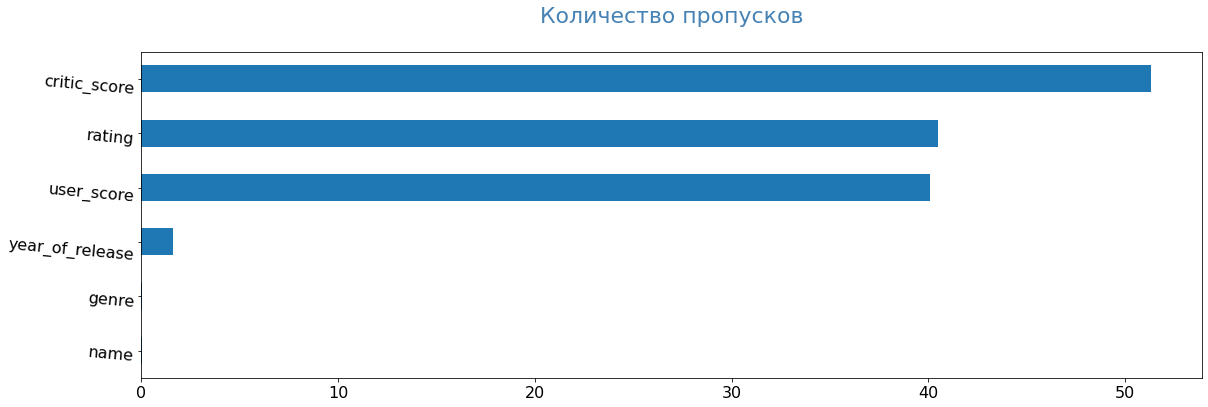

In [11]:
pass_value_barh(data)

Пропуски в столбце genre и name это одни и те же строчки, тк их всего 2, то их можно удалить. На дальнейший анализ они не повлияют

In [12]:
data[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [13]:
#удалим пропуски в столбце name,т.к. их к-во совершенно небольшое
data = data.dropna(subset=['name'])

In [14]:
# check
data.shape

(16713, 11)

Можно заметить множество пропусков в столбцах с оценкой критиков и пользователей, однако удалить их = потерять большое количество данных, поэтому заменим их на "заглушку" для удобства 

Пропуски в столбце critic_score могут означать, что критики не выставили оценки к этим играм или же могла быть какая то ошибка при выгрузке данных например.

In [15]:
data['critic_score'] = data['critic_score'].fillna(-1)#заменим пропуски на -1

In [16]:
data[data['user_score'] == 'tbd'] #проверим к-во строк с 'tbd'

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010.0,Sports,3.45,2.59,0.0,0.66,-1.0,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005.0,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011.0,Sports,1.51,1.03,0.0,0.27,-1.0,tbd,T
645,uDraw Studio,Wii,2010.0,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
657,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,2.15,0.18,0.0,0.07,73.0,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...
16695,Planet Monsters,GBA,2001.0,Action,0.01,0.00,0.0,0.00,67.0,tbd,E
16697,Bust-A-Move 3000,GC,2003.0,Puzzle,0.01,0.00,0.0,0.00,53.0,tbd,E
16698,Mega Brain Boost,DS,2008.0,Puzzle,0.01,0.00,0.0,0.00,48.0,tbd,E
16704,Plushees,DS,2008.0,Simulation,0.01,0.00,0.0,0.00,-1.0,tbd,E


В столбце user_score можно заметить значение 'tbd'. 'tbd'или же  To Be Determined - означает что информация еще не определена или решение еще не принято. Поэтому можно его фактически считать неизвестным нам значением. Другие же пропуски могут означать, что пользователи не ставили им оценки, ошибка при выгрузке данных. 

Тип столбца user_score - odject, однако поскольку это оценка пользователя, т.е. имеет числовое значение, мы должны заменить его на float.

In [17]:
data['user_score'] = data['user_score'].replace('tbd', -1) #заменим tbd на -1
data['user_score'] = data['user_score'].fillna(-1).astype('float') #заменим пропуски на -1 и изменим тип данных

Количество пропусков в столбце year_of_release меньше 2% поэтому можно их удалить. Пропуски могут быть связаны с тем, что либо год во все не указали, либо могла быть проблема с данными при выгрузке например.

In [18]:
#удалим пропуски в столбце
data = data.dropna(subset=['year_of_release'])

In [19]:
# Изменим тип данных в столбце year_of_release 
data['year_of_release'] = data['year_of_release'].astype('Int64')

Мы не можем удалить пропуски в столбце rating, тк иначе потеряем большое количество данных, поэтому заменим их заглушкой. Пропуски в этом столбце говорят о том, что могут быть игры у которых нет рейтинга или его по просту забыли указать.

In [20]:
#заменим пропуски на -1
data['rating'] = data['rating'].fillna(-1)

пропусков не осталось :) 


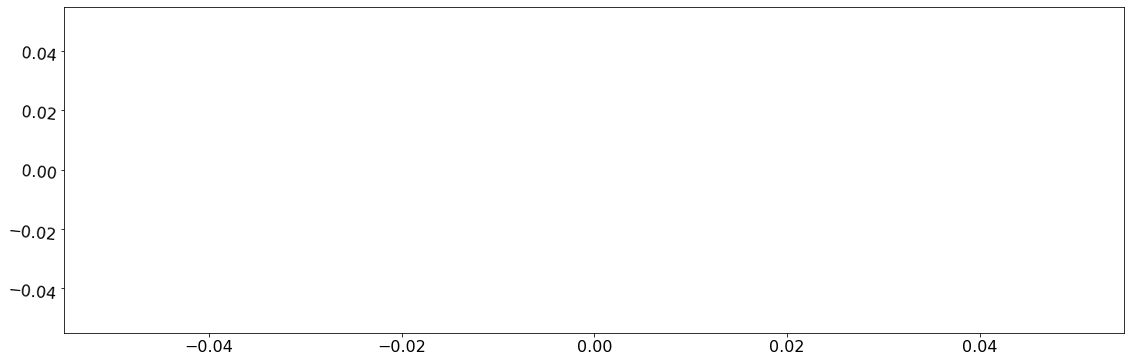

In [21]:
#check
pass_value_barh(data)

Создадим отдельный столбец для суммарных продаж во всех регионах

In [22]:
data['total_sales'] = data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

###  Иследовательский анализ данных

#### Сколько игр выпускалось в разные годы

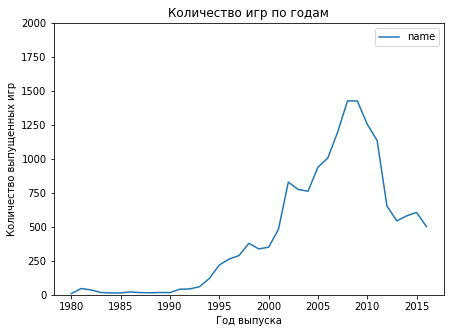

In [23]:
year_games = data.pivot_table(index='year_of_release', values='name', aggfunc='count')
year_games.plot(figsize=(7,5))
plt.ylim(0,2000)
plt.title("Количество игр по годам")
plt.xlabel("Год выпуска")
plt.ylabel("Количество выпущенных игр")
plt.show()

Вывод: Можно заметить что до 2000 количество выпускаемых игр было не очень большим, но примерно с 2000-2002 начался заметный рост. Максимальное количество выпущенных игр было в 2008-2009 годах, после чего мы также можем наблюдать спад.
Можно сказать, что нет не важны данные за все периоды. В период с 1980 по 1994 можно наблюдать очень маленькое количество выпускаемых игр.

#### как менялись продажи по платформам

Сделаем сводную таблицу и построим по ней график, чтобы выбрать платформы с наибольшими продажами

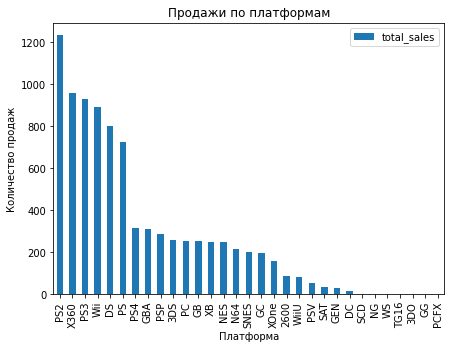

In [24]:
platform_sal = data.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(
    by='total_sales', ascending=False)

platform_sal.plot(kind='bar', figsize=(7,5))
plt.title("Продажи по платформам")
plt.xlabel("Платформа")
plt.ylabel("Количество продаж")
plt.show()

Вывод: судя по графику, можно сделать вывод, что платформы с наибольшими суммарными продажами это PS2, X360, Ps3, Wii, DS, PS. Однако лидером из них однозначно является PS2

In [25]:
#Создадим новый список с 6 платформами с наибольшим к-вом продаж
good_platforms = list(platform_sal.index[:6])


In [26]:
#цикл выводящий распредление по годами для 6 платформ
for platform in good_platforms:
    years_platform = pd.pivot_table(data.query('platform == @platform'), index=['platform','year_of_release'], values='total_sales', aggfunc='sum')
    print(years_platform)
    print("")

                          total_sales
platform year_of_release             
PS2      2000                   39.17
         2001                  166.43
         2002                  205.38
         2003                  184.31
         2004                  211.81
         2005                  160.66
         2006                  103.42
         2007                   75.99
         2008                   53.90
         2009                   26.40
         2010                    5.64
         2011                    0.45

                          total_sales
platform year_of_release             
X360     2005                    8.25
         2006                   51.62
         2007                   95.41
         2008                  135.26
         2009                  120.29
         2010                  170.03
         2011                  143.84
         2012                   99.74
         2013                   88.58
         2014                   34.74
         20

Вывод: Исходя из сводных таблиц можно сделать вывод, что платформы с наиболее высокими суммарными продажами (PS2, X360, Ps3, Wii DS, PS) в среднем функционируют около 8 лет. Поэтому можно сделать вывод, что компании  запускают новые платформы каждые 5-7 лет, давая старым около 2-3 до того момента пока они не перестанут функционировать. 

<AxesSubplot:>

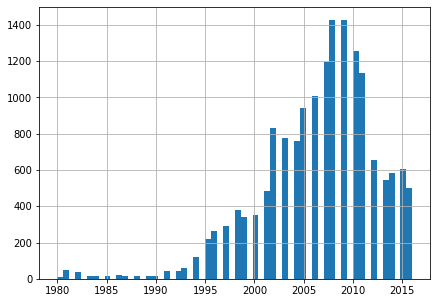

In [27]:
data['year_of_release'].hist(bins=60, figsize=(7,5))

Пиком по количеству выпуска игр можно считать 2008-2009 года. Продажи в 2010-2011 годах все еще были достаточно высокими, а с 2012 года продажи держатся примерно на одном уровне с небольшими скачками. Поэтому возьмем за актуальный период с 2013 по 2016 года.

In [28]:
current_period = data.query('year_of_release >= 2013')
display(current_period.head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-1.0,-1.0,-1,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,-1.0,-1.0,-1,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62


In [29]:
cur_top_platform = pd.pivot_table(current_period, index=['platform','year_of_release'], 
                                     values='total_sales', aggfunc = 'sum')

display(cur_top_platform.head(30))

total_sales
platform year_of_release             
3DS      2013                   56.57
         2014                   43.76
         2015                   27.78
         2016                   15.14
DS       2013                    1.54
PC       2013                   12.38
         2014                   13.28
         2015                    8.52
         2016                    5.25
PS3      2013                  113.25
         2014                   47.76
         2015                   16.82
         2016                    3.60
PS4      2013                   25.99
         2014                  100.00
         2015                  118.90
         2016                   69.25
PSP      2013                    3.14
         2014                    0.24
         2015                    0.12
PSV      2013                   10.59
         2014                   11.90
         2015                    6.25
         2016                    4.25
Wii      2013                    8.59
         2014                    3.75
         2015                    1.14
         2016                    0.18
WiiU     2013                   21.65
         2014                   22.03

In [30]:
display(cur_top_platform.tail(35))

total_sales
platform year_of_release             
PC       2013                   12.38
         2014                   13.28
         2015                    8.52
         2016                    5.25
PS3      2013                  113.25
         2014                   47.76
         2015                   16.82
         2016                    3.60
PS4      2013                   25.99
         2014                  100.00
         2015                  118.90
         2016                   69.25
PSP      2013                    3.14
         2014                    0.24
         2015                    0.12
PSV      2013                   10.59
         2014                   11.90
         2015                    6.25
         2016                    4.25
Wii      2013                    8.59
         2014                    3.75
         2015                    1.14
         2016                    0.18
WiiU     2013                   21.65
         2014                   22.03
         2015                   16.35
         2016                    4.60
X360     2013                   88.58
         2014                   34.74
         2015                   11.96
         2016                    1.52
XOne     2013                   18.96
         2014                   54.07
         2015                   60.14
         2016                   26.15

Вывод: Можно заметить рост продаж у 3Ds,PS4,XOne. Их можно назвать потенциально прибыльными платформами. Падение же продаж можно заметить у PS3,WiiU,X360,PSP.

In [31]:
#сводная таблица для определения лидеров продаж
lider_platform = pd.pivot_table(current_period, index='platform', 
                                     values='total_sales', aggfunc = 'sum')
lider_platform.sort_values('total_sales', ascending=False)

,total_sales
platform,
PS4,314.14
PS3,181.43
XOne,159.32
3DS,143.25
X360,136.80
WiiU,64.63
PC,39.43
PSV,32.99
Wii,13.66


Вывод: Можно сделать вывод, что по продажам лидируют PS4, PS3, Xone, 3DS,X360.

#### График «ящик с усами» по глобальным продажам игр в разбивке по платформам. 

count    303.000000
mean       0.472772
std        1.381347
min        0.010000
25%        0.040000
50%        0.090000
75%        0.280000
max       14.600000
Name: total_sales, dtype: float64

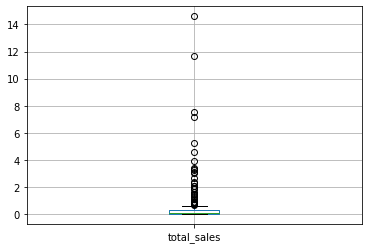

In [32]:
_3DS = current_period.query('platform =="3DS"')
_3DS.boxplot(column = 'total_sales')
_3DS['total_sales'].describe()

Вывод: для платформы 3DS максимальная сумма продаж составляет 14.6 млн, средняя же сумма продаж составляет около 472 тысяч

count    345.000000
mean       0.525884
std        1.451939
min        0.010000
25%        0.040000
50%        0.150000
75%        0.510000
max       21.050000
Name: total_sales, dtype: float64

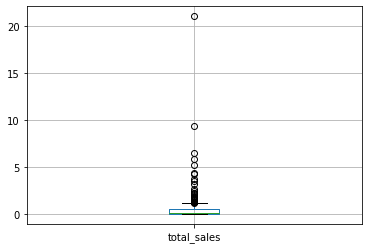

In [33]:
PS3 = current_period.query('platform =="PS3"')
PS3.boxplot(column = 'total_sales')
PS3['total_sales'].describe()

Вывод: Для платформы PS3 максимальная сумма продаж составляет 21 млн, средняя сумма продаж составляет около 525 тысяч

count    186.000000
mean       0.735484
std        1.663275
min        0.010000
25%        0.080000
50%        0.265000
75%        0.795000
max       16.270000
Name: total_sales, dtype: float64

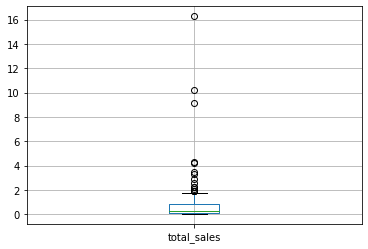

In [34]:
X360 = current_period.query('platform =="X360"')
X360.boxplot(column = 'total_sales')
X360['total_sales'].describe()

Вывод: Для платформы X360 максимальная сумма продаж составляет 16.27 млн, средняя же сумма продаж составляет около 735 тысяч. 

count    392.000000
mean       0.801378
std        1.609456
min        0.010000
25%        0.060000
50%        0.200000
75%        0.730000
max       14.630000
Name: total_sales, dtype: float64

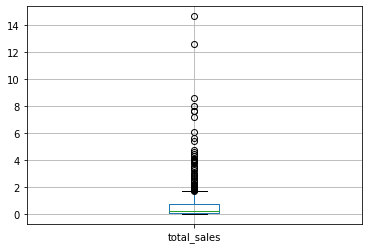

In [35]:
PS4 = current_period.query('platform =="PS4"')
PS4.boxplot(column = 'total_sales')
PS4['total_sales'].describe()

Вывод: Для платформы PS4 максимальная сумма продаж составляет 14.63 млн, средняя же сумма продаж составляет 803 тысячи.

count    247.000000
mean       0.645020
std        1.036139
min        0.010000
25%        0.060000
50%        0.220000
75%        0.685000
max        7.390000
Name: total_sales, dtype: float64

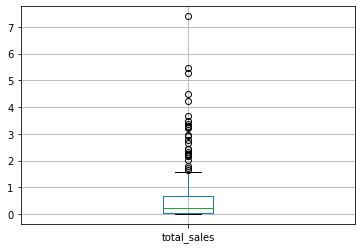

In [36]:
XOne = current_period.query('platform =="XOne"')
XOne.boxplot(column = 'total_sales')
XOne['total_sales'].describe()

Вывод: Для платформы XOne максимальная сумма продаж составляет 7.39 млн, средняя же сумма продаж составляет около 645 тысяч.

Вывод: Можно выделить платформы x360 (16.27, 735к) и PS3(21 млн, 525к), как платформы с наибольшей максимальной суммой продаж и наибольшими средними суммами продаж.Также можно заметить платформы с наименьшими суммами продаж и наименьшими средними, а именно Xone (7.39 млн, 645 тысяч).


#### как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. 

Возьмем платформу PS3, потому как она является одним из лидеров как за предыдущие годы, так и за актуальный период.

In [37]:
#сделаем срез данных для платформы PS3 и оценки критиков
PS3_platform = data.query('(platform == "PS3") & (critic_score > 0)')
display(PS3_platform)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79
37,Call of Duty: Modern Warfare 3,PS3,2011,Shooter,5.54,5.73,0.49,1.57,88.0,3.2,M,13.33
41,Call of Duty: Black Ops,PS3,2010,Shooter,5.99,4.37,0.48,1.79,88.0,6.4,M,12.63
54,Gran Turismo 5,PS3,2010,Racing,2.96,4.82,0.81,2.11,84.0,7.5,E,10.70
...,...,...,...,...,...,...,...,...,...,...,...,...
15649,Darksiders,PS3,2010,Action,0.01,0.00,0.00,0.00,82.0,7.9,M,0.01
15742,Invizimals: The Lost Kingdom,PS3,2013,Action,0.00,0.02,0.00,0.00,50.0,5.0,E10+,0.02
15880,Turbo: Super Stunt Squad,PS3,2013,Sports,0.00,0.01,0.00,0.00,38.0,-1.0,E,0.01
16146,Don Bradman Cricket 14,PS3,2014,Sports,0.00,0.01,0.00,0.00,73.0,6.9,E,0.01


<AxesSubplot:xlabel='critic_score', ylabel='total_sales'>

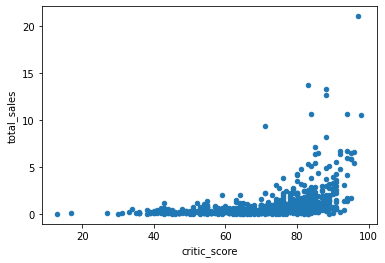

In [38]:
#создадим диаграмму 
PS3_platform.plot(x='critic_score', y='total_sales', kind='scatter')

Вывод: можно заметить, что с ростом оценок от критиков растут и продажи по платформе.

In [39]:
#сделаем срез данных для платформы PS3 и оценки пользователей
PS3_platform = data.query('(platform == "PS3") & (user_score > 0)')
display(PS3_platform)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79
37,Call of Duty: Modern Warfare 3,PS3,2011,Shooter,5.54,5.73,0.49,1.57,88.0,3.2,M,13.33
41,Call of Duty: Black Ops,PS3,2010,Shooter,5.99,4.37,0.48,1.79,88.0,6.4,M,12.63
54,Gran Turismo 5,PS3,2010,Racing,2.96,4.82,0.81,2.11,84.0,7.5,E,10.70
...,...,...,...,...,...,...,...,...,...,...,...,...
15567,Tom Clancy's Splinter Cell Classic Trilogy HD,PS3,2011,Action,0.02,0.00,0.00,0.00,67.0,6.8,M,0.02
15649,Darksiders,PS3,2010,Action,0.01,0.00,0.00,0.00,82.0,7.9,M,0.01
15742,Invizimals: The Lost Kingdom,PS3,2013,Action,0.00,0.02,0.00,0.00,50.0,5.0,E10+,0.02
16146,Don Bradman Cricket 14,PS3,2014,Sports,0.00,0.01,0.00,0.00,73.0,6.9,E,0.01


<AxesSubplot:xlabel='user_score', ylabel='total_sales'>

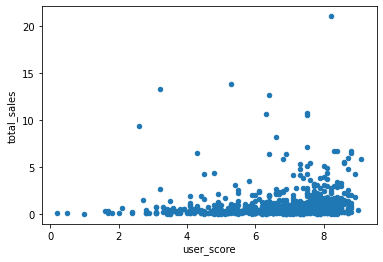

In [40]:
#создадим диаграмму 
PS3_platform.plot(x='user_score', y='total_sales', kind='scatter')

Вывод: Зависимость роста продаж и роста оценок от пользователя аналогична предыдущей. Чем выше оценки пользователей, тем выше продажи у игры.

In [41]:
PS3_corr = PS3_platform[['total_sales' ,'critic_score', 'user_score']]
PS3_corr.corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.299975,0.128416
critic_score,0.299975,1.000000,0.418592
user_score,0.128416,0.418592,1.000000


Вывод: Исходя из значений, можно сказать, что между продажами и оценкой критиков наблюдается умеренная взаимосвязь, а между продажами и оценкой пользователей слабая. Однако можно также заметить умеренную взаимосвязь между оценками пользователей и критиков.

Как пример, можем рассмотреть еще одну популярную платформу, чтобы посмотреть кардинально ли изменяется зависимость продаж от оценок критиков и пользователей.

In [42]:
# сделаем срез данных для платформы 3DS и оценок критиков
PS4_platform = data.query('(platform == "PS4") & (critic_score > 0)')
display(PS4_platform)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
92,Call of Duty: Advanced Warfare,PS4,2014,Shooter,2.81,3.48,0.14,1.23,83.0,5.7,M,7.66
94,FIFA 17,PS4,2016,Sports,0.66,5.75,0.08,1.11,85.0,5.0,E,7.60
105,Fallout 4,PS4,2015,Role-Playing,2.53,3.27,0.24,1.13,87.0,6.5,M,7.17
...,...,...,...,...,...,...,...,...,...,...,...,...
16486,Super Dungeon Bros,PS4,2016,Action,0.01,0.00,0.00,0.00,42.0,2.3,E10+,0.01
16499,Sherlock Holmes: The Devil's Daughter,PS4,2016,Adventure,0.01,0.00,0.00,0.00,70.0,6.8,T,0.01
16500,Root Letter,PS4,2016,Adventure,0.00,0.00,0.01,0.00,69.0,7.5,-1,0.01
16526,Dungeons 2,PS4,2016,Role-Playing,0.01,0.00,0.00,0.00,61.0,7.9,T,0.01


<AxesSubplot:xlabel='critic_score', ylabel='total_sales'>

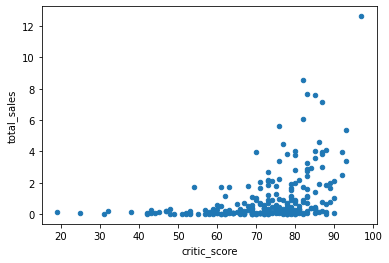

In [43]:
#создадим диаграмму 
PS4_platform.plot(x='critic_score', y='total_sales', kind='scatter')

Можно также заметить тенденцию между ростом оценок критиков и ростом продаж.

In [44]:
# сделаем срез данных для платформы 3DS и оценок пользователей
PS4_platform = data.query('(platform == "PS4") & (user_score > 0)')
display(PS4_platform)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
92,Call of Duty: Advanced Warfare,PS4,2014,Shooter,2.81,3.48,0.14,1.23,83.0,5.7,M,7.66
94,FIFA 17,PS4,2016,Sports,0.66,5.75,0.08,1.11,85.0,5.0,E,7.60
105,Fallout 4,PS4,2015,Role-Playing,2.53,3.27,0.24,1.13,87.0,6.5,M,7.17
...,...,...,...,...,...,...,...,...,...,...,...,...
16486,Super Dungeon Bros,PS4,2016,Action,0.01,0.00,0.00,0.00,42.0,2.3,E10+,0.01
16499,Sherlock Holmes: The Devil's Daughter,PS4,2016,Adventure,0.01,0.00,0.00,0.00,70.0,6.8,T,0.01
16500,Root Letter,PS4,2016,Adventure,0.00,0.00,0.01,0.00,69.0,7.5,-1,0.01
16526,Dungeons 2,PS4,2016,Role-Playing,0.01,0.00,0.00,0.00,61.0,7.9,T,0.01


<AxesSubplot:xlabel='user_score', ylabel='total_sales'>

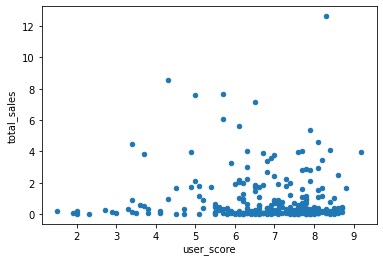

In [45]:
#создадим диаграмму 
PS4_platform.plot(x='user_score', y='total_sales', kind='scatter')

In [46]:
PS4_corr = PS4_platform[['total_sales' ,'critic_score', 'user_score']]
PS4_corr.corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.350407,-0.031957
critic_score,0.350407,1.000000,0.385579
user_score,-0.031957,0.385579,1.000000


Для платформы PS4 мы можем заметить аналогичную ситуацию как у платформы PS3. Можем ожидать схожую ситуацию и для других популярных платформ. Однако для этой платформы мы можем увидеть умеренную взаимосвязь между оценками критиков и продажами, также видно умеренную взаимосвязь между оценками критиков и оценками пользователей. Однако практически нет связи между оценками пользователей и продажами. 

Вывод:Можно сказать, что продажи игр на других платформах также зависят от оценок критиков и пользователей, что вполне логично. Люди более вероятно купят игру с более высокими оценками от других пользователей и критиков, чем с низкими. 

#### Общее распределение игр по жанрам

In [47]:
#Создадим сводную таблицу с жанрами и продажами
genre_distribution = pd.pivot_table(current_period, index='genre', values='total_sales', aggfunc='median')
genre_distribution = genre_distribution.sort_values('total_sales', ascending=False)
display(genre_distribution)

,total_sales
genre,
Shooter,0.450
Sports,0.240
Platform,0.225
Role-Playing,0.125
Fighting,0.125
Racing,0.120
Action,0.110
Simulation,0.100
Misc,0.100


Вывод: Самыми прибыльными жанрами можно назвать  Shooter, sports, Platform,  Role-Playing. Можно однозначно выделить Shooter как самый прибыльный жанр, можно увидеть значительный отрыв от остальных прибыльных жанров. Самыми не прибыльными жанрами можно назвать Adventure и Puzzle.

### Портрет пользователя каждого региона

#### Самые популярные платформы (топ-5)

Создадим сводную таблицу платформ и продаж для Северной Америки. Выделим топ 5 платформ.

In [48]:
na_platform = pd.pivot_table(data, index='platform', values='na_sales', aggfunc='sum').sort_values('na_sales', ascending=False)
na_platform = na_platform[:5]
display(na_platform)

,na_sales
platform,
X360,595.74
PS2,572.92
Wii,486.87
PS3,390.13
DS,380.31


Создадим сводную таблицу платформ и продаж для Европы. Выделим топ 5 платформ.

In [49]:
eu_platform = pd.pivot_table(data, index='platform', values='eu_sales', aggfunc='sum').sort_values('eu_sales', ascending=False)
eu_platform = eu_platform[:5]
display(eu_platform)

,eu_sales
platform,
PS2,332.63
PS3,327.21
X360,268.32
Wii,258.32
PS,212.39


Создадим сводную таблицу платформ и продаж для Японии. Выделим топ 5 платформ.

In [50]:
jp_platform  = pd.pivot_table(data, index='platform', values='jp_sales', aggfunc='sum').sort_values('jp_sales', ascending=False)
jp_platform = jp_platform[:5]
display(jp_platform)

,jp_sales
platform,
DS,175.02
PS,139.78
PS2,137.54
SNES,116.55
3DS,100.62


Вывод: Можно заметить сходство в топ 5 платформ между европой и северной америкой. PS2 в обоих топах занимает высокие позиции( 1 место в Европе, 2 место в Северной Америке). Также можно заметить что топ 5 платформ для Северной Америки и европы схож по платформам, но отличается по продажам.
Топ 5 платформ в Японии  отличается. Лидерами топа для Японии являются DS и PS, которые замыкают топ 5 для Северной америки и европы. 
Можно также заметить значительную разницу в продажах. Самые высокие суммы продаж в Северной Америке, после в Европе и в Японии соотвественно. 
Например, продажи платформы PS2 в Северной Америке больше примерно в 1,7 раз чем в Европе. При том что эта платформа занимает в европе 1 место по продажам. Продажи PS2 в Северной Америке превышают продажи PS2 в Японии примерно в 4,15 раз.

#### Самые популярные жанры (топ-5). 

Создадим сводную таблицу для жанров и продаж в Северной Америке

In [51]:
na_genre = pd.pivot_table(data, index='genre', values='na_sales', aggfunc='sum').sort_values('na_sales', ascending=False)
na_genre = na_genre[:5]
display(na_genre)

,na_sales
genre,
Action,863.17
Sports,671.20
Shooter,584.83
Platform,444.44
Misc,399.57


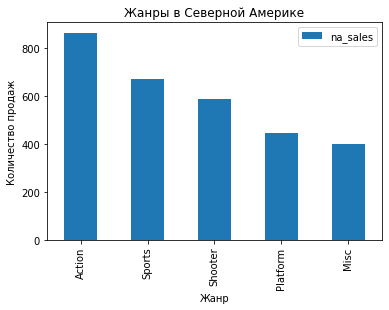

In [52]:
na_genre.plot(kind='bar')
plt.title("Жанры в Северной Америке")
plt.xlabel("Жанр")
plt.ylabel("Количество продаж")
plt.show()

Создадим сводную таблицу для жанров и продаж в Европе

In [53]:
eu_genre = pd.pivot_table(data, index='genre', values='eu_sales', aggfunc='sum').sort_values('eu_sales', ascending=False)
eu_genre = eu_genre[:5]
display(eu_genre)

,eu_sales
genre,
Action,510.99
Sports,371.33
Shooter,314.52
Racing,234.49
Misc,210.60


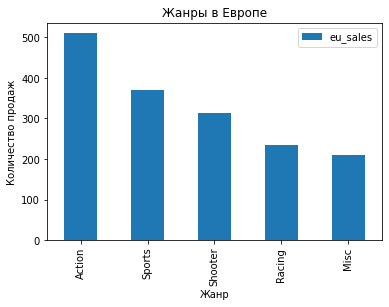

In [54]:
eu_genre.plot(kind='bar')
plt.title("Жанры в Европе")
plt.xlabel("Жанр")
plt.ylabel("Количество продаж")
plt.show()

Создадим сводную таблицу для жанров и продаж в Японии

In [55]:
jp_genre  = pd.pivot_table(data, index='genre', values='jp_sales', aggfunc='sum').sort_values('jp_sales', ascending=False)
jp_genre = jp_genre[:5]
display(jp_genre)

,jp_sales
genre,
Role-Playing,353.39
Action,160.14
Sports,134.93
Platform,130.71
Misc,107.02


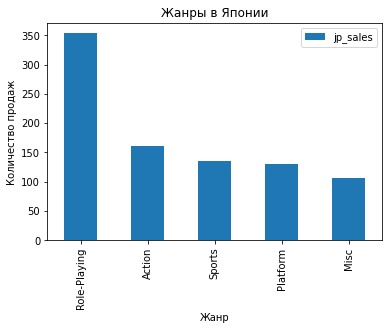

In [56]:
jp_genre.plot(kind='bar')
plt.title("Жанры в Японии")
plt.xlabel("Жанр")
plt.ylabel("Количество продаж")
plt.show()

Вывод: Самым прибыльным жанром в Северной Америке и Европе является Action. Продажи составляют 863 и 510 соотвественно. Продажи Action в Северной Америке превышают примерно в 1,7 раз продажи в Европе
Для Японии самым прибыльным жанром является Role-Playing, однако Action занимает 2 место.( 160.14). Продажи Action в Северной Америке превышают примерно в в 5,4 раз продажи в Японии.
Топ 5 жанров в Северной Америке и Европе очень похожи, отличаются лишь суммой продаж. (в европе продажи ниже). Топ 5 жанров в японии отличается лишь тем, что самым популярным жанром является Role-Playing. Однако в целом в каждом топе Action остается популярным и занимает лидирующие позиции.

#### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

Создадим сводную таблицу для взаимосвязи рейтингов и продаж в Северной Америке

In [57]:
na_rating = pd.pivot_table(data, index='rating', values='na_sales', aggfunc='sum').sort_values('na_sales', ascending=False)
display(na_rating)

,na_sales
rating,
E,1274.24
-1,1225.84
T,747.60
M,742.89
E10+,345.50
K-A,2.56
EC,1.53
AO,1.26
RP,0.00


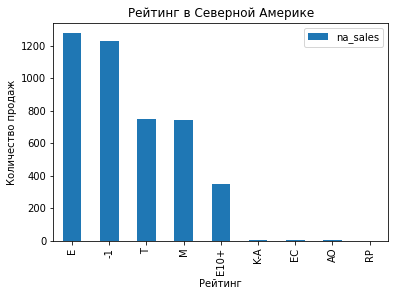

In [58]:
na_rating.plot(kind='bar')
plt.title("Рейтинг в Северной Америке")
plt.xlabel("Рейтинг")
plt.ylabel("Количество продаж")
plt.show()

Создадим сводную таблицу для взаимосвязи рейтингов и продаж в Европе

In [59]:
eu_rating = pd.pivot_table(data, index='rating', values='eu_sales', aggfunc='sum').sort_values('eu_sales', ascending=False)
display(eu_rating)

,eu_sales
rating,
E,703.87
-1,609.65
M,480.00
T,421.79
E10+,183.35
AO,0.61
K-A,0.27
EC,0.11
RP,0.03


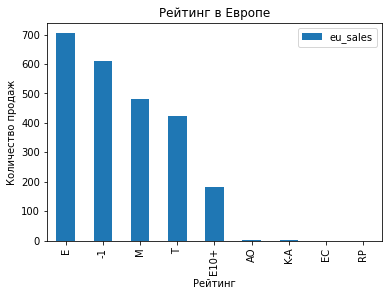

In [60]:
eu_rating.plot(kind='bar')
plt.title("Рейтинг в Европе")
plt.xlabel("Рейтинг")
plt.ylabel("Количество продаж")
plt.show()

Создадим сводную таблицу для взаимосвязи рейтингов и продаж в Японии

In [61]:
jp_rating = pd.pivot_table(data, index='rating', values='jp_sales', aggfunc='sum').sort_values('jp_sales', ascending=False)
display(jp_rating)

,jp_sales
rating,
-1,836.74
E,197.96
T,150.70
M,63.58
E10+,40.20
K-A,1.46
AO,0.00
EC,0.00
RP,0.00


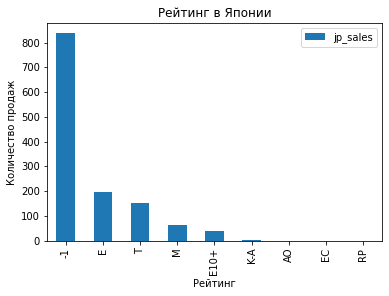

In [62]:
jp_rating.plot(kind='bar')
plt.title("Рейтинг в Японии")
plt.xlabel("Рейтинг")
plt.ylabel("Количество продаж")
plt.show()

Вывод: можно сказать, что для Северной Америки и Европы лидирует рейтинг E, что вполне логично ведь это игры подходящие для всех возрастов. Лидирующие позиции также занимают рейтинги T и M для каждого региона. Однако можно заметить, что в Японии больше всего игр без рейтинга, а такде они занимают 2 место по продажам в Европе и Америке. В целом ситуация в рейтингах достаточно схожая отличается лишь суммой продаж. 
Возможно, производители игр в японии в силу не стремятся получить для своей игры какой-либо рейтинг. Это видно по огромной разнице в продажах. Продажи игр без рейтинга больше почти в 4 раза продаж игр с самыми популярными рейтингами. В Северной Америке и Европе все же лидирует рейтинг E, однако отрыв между ними и играми без рейтинга невелик. Можно сказать, что В Японии наиболее популярны игры без рейтинга, а Европе и Америке в равной мере предпочитают игры как с рейтингом Е так и игры без рейтинга вовсе.


### Проверьте гипотезы

Для проверки гипотез был выбран t-тест, потому что выборки достаточно велики и равны по размеру между собой, значит и дисперсии генеральных совокупностей должны быть равны. Поэтому мы можем сравнивать средние этим тестом.

#### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

In [63]:
XOne_rating = current_period.query('platform == "XOne"')['user_score']

In [64]:
PC_rating = current_period.query('platform == "PC"')['user_score']

Нулевая гипотеза: Средние пользовательские рейтинги платформы Xbox One =  Средние пользовательские рейтинги платформы PC 

Альтернативная гипотеза: Средние пользовательские рейтинги платформы Xbox One ≠ Средние пользовательские рейтинги платформы PC 

In [65]:
from scipy import stats as st

In [66]:
results = st.ttest_ind(XOne_rating, PC_rating)
# alpha = задайте значение уровня значимости
alpha = 0.05
# вывод значения p-value на экран 
print(results.pvalue)
# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

0.20111399900783597
Не получилось отвергнуть нулевую гипотезу


Вывод: таким образом, можно сделать вывод, что нулевая гипотеза верна. Т.е. Средние пользовательские рейтинги платформы Xbox One = средним пользовательским рейтингам платформы PC. 

#### Средние пользовательские рейтинги жанров Action и Sports разные.

In [67]:
action_rating = current_period.query('genre == "Action"')['user_score']

In [68]:
sports_rating = current_period.query('genre == "Sports"')['user_score']

Нулевая гипотеза: Средние пользовательские рейтинги жанра Action = Средние пользовательские рейтинги жанра Sports .

Альтернативная гипотеза: Средние пользовательские рейтинги жанра Action ≠ Средние пользовательские рейтинги жанра Sports.

In [69]:
results = st.ttest_ind( action_rating, sports_rating)
# alpha = задайте значение уровня значимости
alpha = 0.05
# вывод значения p-value на экран 
print(results.pvalue)
# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

0.02193663336455412
Отвергаем нулевую гипотезу


Вывод: таким образом, нулевую гипотезу нужно отвергнуть. Значит, Средние пользовательские рейтинги жанра Action ≠ Средние пользовательские рейтинги жанра Sports.

Для ревьювера:  я верно поняла, что нулевая гипотеза должна быть равенством или что-то еще должно быть? 

### Общий вывод

Вывод:В ходе работы над проектом проводилось исследование продаж игр. Была проведена предобработка данных, где были удалены пропуски(2 строчки и пропуски в столбце year_of_release), заменены нижним регистром заголовки таблицы, добавлены "заглушки" в столбцы, где это требовалось, а также изменен тип данных. 

В ходе исследовательского анализа удалось узнать сколько игр выпускалось в разные годы. Можно заметить что до 2000 количество выпускаемых игр было не очень большим, но примерно с 2000-2002 начался заметный рост. Максимальное количество выпущенных игр было в 2008-2009 годах(1427,1426 игр в год соотвественно), после чего мы также можем наблюдать спад. К 2016 году стало около 502 игр в год. Было проведено исследование как менялись продажи по платформам. Удалось выяснить, что платформы с наиболее высокими суммарными продажами - PS,X360,PS3,Wii,DS,PS. В среднем платформа функционирует около 8 лет. Компании запускают новые платформы каждые 5-7 лет, давая старым дожить 2-3 года.

За актуальный период был принят период с 2013 по 2016 года, потому как 2008-2009 года был пик продаж. Продажи в 2010-2012 годах также были достататочно высокими, а после этого ситуация немного выравнялась. Потенциально прибыльными платформами были выбраны 3DS,PS4,Xone. Для актуального периода также были отобраны лидеры среди платформ - PS3,X360,PS4,3DS, XOne. Для лидеров были построены 'ящики с усами' на их основании можно выделить платформы с наибольшими суммарными продажами (X360 - 16.27 млн, PS3 - 21 млн), а также с наименьшими суммарными продажами Xone (7.39 млн - максимальная продажа, 645тысяч - средние продажи).

Было проведено исследование как влияют на продажи отзывы критиков и пользователей. Оказалось, что чем выше оценки пользователей и критиков, тем выше продажи на платформе. Также удалось выяснить самые популярные жанры - Shooter, Sports, Platform, Role-Playing. Самыми неприбыльными жанрами являются - Adventure и Puzzle. Жанр Shooter является самым прибыльным с достаточным отрывом.

Исследовалось также портрет пользователя для каждого региона. Для Северной Америки, Европы и Японии были вычислены топ 5 платформ. Топ 5 платформ очень схожи у Северной Америки и Европы. Топ платформ для Японии немного отличается.Лидером продаж для Северной Америки и Европы считается PS2(1 место в Европе, 2 место в Северной Америке). Лидерами продаж в Японии же являются платформы Ds, PS. Они в свою очередь замыкают топ для Северной Америки и Европы.

Были выявлены топ 5 жанров для каждого региона. Для Северной Америки и Европы топы достачно похожи, первое место занимает Action. Для Японии первое место занимает Role-Playing, однако на 2 месте также стоит Action.

Однако было выявлено что для Северной Америки и Европы лидирует рейтинг E, что вполне логично, эти игры предназначены для людей любых возрастов. Однако в Японии со значительным отрывом лидирют игры без рейтинга, также игры без рейтинга занимают второе метсо по популярности в Европе и Северной Америке. В целом популярность рейтингов довольно схожа для регионов, отличается лишь ценой на продажи.
 
В ходе работы над проектом была также проведена проверка гипотез. Для первой гипотезы была сформулирована нулевая гипотеза:  Средние пользовательские рейтинги платформы Xbox One = Средние пользовательские рейтинги платформы PC. А также альтернативная: Средние пользовательские рейтинги платформы Xbox One ≠ Средние пользовательские рейтинги платформы PC. В ходе исследование оказалось, что нулевую гипотезу нельзя опровергнуть.

Для второй гипотезы была сформулирована нулевая гипотеза: Средние пользовательские рейтинги жанра Action = Средние пользовательские рейтинги жанра Sports .
А также альтернативная гипотеза: Средние пользовательские рейтинги жанра Action ≠ Средние пользовательские рейтинги жанра Sports. В ходе исследование оказалось, что мы отвергаем нулевую гипотезу.